What are Recommender Systems?

recommender systems are algorithms designed to suggest items (such as movies, products, or music) based on user preferences.

Example: How Netflix recommends movies or Spotify suggests music based on your listening history.

Why Are They Important?

Use cases: Personalization in everyday life (e.g., Amazon product recommendations, YouTube video suggestions).

Talk about how it improves user experience, drives sales, and increases engagement.

Types of Recommender Systems:

A knowledge based recommender system:

recommends items based on knowledge about the domain (products, services) and explicit user requirements. Instead of relying on patterns from user behavior or item characteristics, it uses logic or rules.

Example: A travel website that suggests vacation packages based on specific user preferences, such as budget, destination type, or season.

Collaborative Filtering (CF):

User-based CF: Recommends items based on similar users' preferences.

Example: If you and another person like similar movies, the system will recommend movies that person has liked but you haven’t watched yet.

Item-based CF: Recommends items similar to what the user has liked in the past.

Example: If you liked "The Matrix," you might like "Inception" because both are science fiction.

Content-Based Filtering:

Recommends items based on the characteristics of the item and the user’s past interactions.

Example: If a user likes action movies, the system will suggest more action movies.

How It Works:

The system looks at the content or attributes of items that the user has interacted with or liked before.

It then calculates similarities between the content of previously liked items and other items in the catalog and recommends the most similar ones.

Example:

If a user frequently watches sci-fi movies, the system may recommend more sci-fi movies 
based on keywords like "space," "future," or "robots" from previously watched movies.

# User-based Collaborative Filtering using Pandas

In this notebook I explore a technique to recommend items, called __collaborative filtering__.

The basic idea of user-based collaborative filtering for recommender systems is the following:
The task is to recommend items to a given user x. 

Which items do we recommend? First, we find N other users in the neighborhood of user x. Then, we predict the rating of unrated items by user x by using the ratings of the N other users. The recommended items must not be rated yet by user X. 

I use the __MovieLens 100K Dataset__ (https://grouplens.org/datasets/movielens/). Copy the dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip, and unzip it into a folder.

2 files of the dataset are used:
- `data.txt` contains the 100k ratings.
- `item.txt` provides a mapping from a movie id to the name of the movie.

In [52]:
# data manipulation
import numpy as np
import pandas as pd

In [53]:
# paths to the files. download them from http://files.grouplens.org/datasets/movielens/ml-100k.zip if you don't have them yet
MOVIE_RATINGS_PATH = 'data/data.txt'
MOVIE_NAMES_PATH = 'data/item.txt'

# Reading the Ratings Data

In [54]:
def read_ratings(path_to_ratings):
    """
        Read the raw data of the movie ratings.
        
        Returns a list of tuples:
        (user id, movie id, rating)
    """
    data = []
    with open(path_to_ratings) as f:
        for line in f:
            # user id | item id | rating | timestamp
            pieces = line.split()
            user_id = int(pieces[0])
            movie_id = int(pieces[1])
            rating = float(pieces[2])
            data.append((user_id, movie_id, rating))
        
    return data

In [55]:
def read_names(path_to_names):
    data = {}
    with open(path_to_names, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            pieces = line.split('|')
            movie_id = int(pieces[0])
            title = pieces[1]
            data[movie_id] = title
    return data

In [56]:
ratings = read_ratings(MOVIE_RATINGS_PATH)
print(type(ratings))
ratings = pd.DataFrame(data=ratings, columns=['user', 'movie', 'rating']) #.sample(100, random_state=42)
ratings = ratings.astype(int)
ratings.head()
# ratings.dtypes

<class 'list'>


,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [57]:
# number of unique movies
ratings.movie.nunique()

1682

In [58]:
# number of unique users
ratings.user.nunique()

943

# Pick a random sample for testing purposes

In [59]:
sample = ratings.sample(random_state=42)
user_id = sample.user.values[0]
item_id = sample.movie.values[0]

In [60]:
user_id, item_id

(877, 381)

The purpose of this step is to randomly select a user and a movie from the dataset for testing. 

This selection is used in later stages of the notebook to compute similarities and make recommendations for the given user and movie.

# Transforming the user rating data

The Movielens dataset comes in the so-called _long format_. The dataset is structured as tuples of

`user id, movie id, rating`

That means, multiple rows may have the same user_id. One row for every movie that the user rated.

In user-based collaborative filtering, we need the data in the long format.

Therefore, we conver from long to wide format.

In [61]:
# convert long to wide
ratings_raw = ratings.copy()
ratings = ratings.pivot(index='user', columns='movie', values='rating')

This code creates a matrix where:

Rows represent users.

Columns represent movies.

The values in the matrix are the ratings that users gave to the movies.

This transformation allows easier computation of user similarities because now each row (user) contains the ratings they gave to all the movies.

In [62]:
ratings.shape

(943, 1682)

In [63]:
ratings.head()

movie,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each entry represents the rating a user gave to a movie.

Missing values (NaN) indicate that the user did not rate that particular movie.

In [64]:
# select user, movie
ratings.loc[user_id, item_id]

4.0

In [65]:
# ratings vector of specific user
ratings.loc[user_id, :].sample(10)

movie
1191   NaN
1196   NaN
580    NaN
194    NaN
1672   NaN
730    NaN
652    NaN
660    NaN
1117   NaN
141    NaN
Name: 877, dtype: float64

# Measuring similarity between users

After converting the dataset into the wide format, with rows as ratings vector of every user.

The ratings vectors are used to measure the similarity or dissimilarity between users. When 2 users have given the same movies the same ratings, we can say that the 2 users are similar with respect to their movie taste. Vice versa, when 2 users have rated the same movie very differently, the users have very different taste in movies.

User-based collaborative filtering focuses on finding users with very similar taste in movies to recommend movies to someone.

Here, we use the Pearson correlation to measure similarity between 2 ratings vectors (= 2 users). Pearson correlation has a value between -1 and +1. 0 means no correlation. +1 means very similar. -1 means very dissimilar.

We compute the similarity of a given user with all the other users in the dataset.

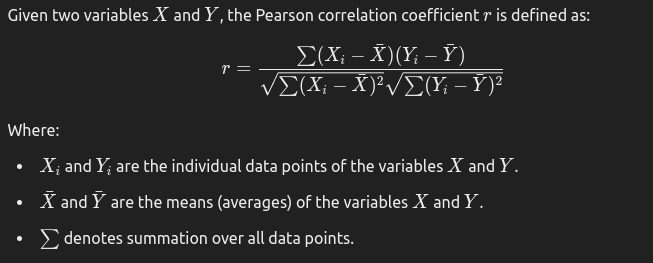

why:

User A might always rate 4 or 5 stars, while User B rates 2 or 3 stars, but they may have similar taste in movies. Pearson correlation will adjust for this by comparing how the ratings deviate from each user's average rating, so both users could still be seen as similar.

In [66]:
def pearson_similarity(v1, v2):
    """
        Compute the Pearson correlation between to ratings vectors.
        
        pd.corr() function can handle missing data.
        
        parameters: 
        - v1, v2: pd.Series, ratings vectors
        
        returns:
        - float    
    """
    pearson = v1.corr(v2)
    
    return pearson

In [67]:
# let us test
pearson_similarity(
    pd.Series([1, 2, 3, 4, 5, np.NaN]), 
    pd.Series([2, 1, 4, 5, np.NaN, 1])
)

0.8485281374238571

Pearson correlation measures the linear relationship between two variables (in this case, two users’ ratings). It returns a value between:

+1: perfectly correlated (users have the same taste).

0: no correlation.

-1: perfectly dissimilar (opposite tastes).

In [68]:
def compute_similarities(user_id, ratings_matrix):
    """
        Compute the similarity of a given user with all the other users in the dataset.
        
        Remove the similarity value for the given user from the result.
        
        returns:
            - a pd.Series with the user id's as index, and similarity as series values
    """
    # get ratings of user to re-use in the similarity computation
    ratings_user = ratings_matrix.loc[user_id,:]
    
    # calculate the similarity between the given user and the other users
    similarities = ratings_matrix.apply(
        lambda row: pearson_similarity(ratings_user, row), 
        axis=1)
    
    print(type(similarities))

    similarities = similarities.to_frame(name='similarity')

    # find most similar users to the given user
    similarities = similarities.sort_values(by='similarity', ascending=False)
    
    # drop the similarity of the user (should be ~1 anyways)
    similarities = similarities.drop(user_id)
    
    return similarities

In [69]:
# let us test
similarities = compute_similarities(user_id, ratings)
similarities.head()

<class 'pandas.core.series.Series'>


c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,similarity
user,
917,1.0
300,1.0
386,1.0
789,1.0
869,1.0


# Predicting Movie Ratings

The user similarities allow to predict the rating that a user would give to an unrated movie. The recipe to make a rating prediction goes as follows:
- find the N most similar neighbors of the user, who have rated the given movie
- average the rating of that movie of the N neighbors of the user

In [70]:
def predict_rating(item_id, ratings, similarities, N=10):
    """
        Predict the rating of a given item by a user, given the ratings of similar users.
        Takes the N users with the highest similarity measure, AND who have rated the given item.
        Returns the average rating of the most similar users who previously rated the item.
        
        parameters:
        - item_id: int, item that needs a rating prediction
        - ratings: pd.DataFrame
        - similarities: pd.DataFrame
        - N: int, number of neighbors to use for rating prediction
        
        returns:
        - a float representing the predicted rating for the given item
    """
    # get the ratings of all users for the specific item
    users_ratings = ratings.loc[:, item_id]
    
    print("####################################################")
    print("users_ratings", users_ratings)
    
    print("####################################################")
    print(~users_ratings.isnull())
    
    # only keep users who rated the given item, otherwise you won't be able to generate a prediction based on the users ratings
    most_similar_users_who_rated_item = similarities.loc[~users_ratings.isnull()]
    
    print("####################################################")
    print("most_similar_users_who_rated_item", most_similar_users_who_rated_item)
    
    # keep N users with highest similarities to given user who also rated the given item
    N_most_similar_users = most_similar_users_who_rated_item.head(N)
    
    print("####################################################")
    print("N_most_similar_users", N_most_similar_users)
    
    # find ratings item for most similar users:
    ratings_for_item = ratings.loc[N_most_similar_users.index, item_id]
    
    print("####################################################")
    print("ratings_for_item", ratings_for_item)
    
    # predict the rating of the item by averaging the ratings of that item of the most similar users
    return ratings_for_item.mean()

In [71]:
# number of neighbors of user
N_NEIGHBORS = 10

# number of recommendations
N_RECOMMENDATIONS = 5

In [72]:
# let us test
predict_rating(item_id, ratings, similarities, N=N_NEIGHBORS)

####################################################
users_ratings user
1      NaN
2      NaN
3      NaN
4      NaN
5      1.0
      ... 
939    NaN
940    NaN
941    NaN
942    NaN
943    NaN
Name: 381, Length: 943, dtype: float64
####################################################
user
1      False
2      False
3      False
4      False
5       True
       ...  
939    False
940    False
941    False
942    False
943    False
Name: 381, Length: 943, dtype: bool
####################################################
most_similar_users_who_rated_item       similarity
user            
233     0.712137
478     0.659380
379     0.499274
576     0.485643
89      0.442138
...          ...
914    -0.282843
654    -0.368804
819    -0.394405
436    -0.462910
196    -0.503581

[99 rows x 1 columns]
####################################################
N_most_similar_users       similarity
user            
233     0.712137
478     0.659380
379     0.499274
576     0.485643
89      0.442138
437    

4.0

# Recommending movies

Once we can predict what rating a user will give to a given movie, recommending movies to that user becomes straight forward.

We recommend movies as follows:
- find the movies that the user has not rated.
- predict the rating that the user would give to these unrated movies.
- find the N movies with the highest ratings.

In [73]:
movie_names = read_names(MOVIE_NAMES_PATH)

In [74]:
def recommend(user_id, ratings, movie_names, n_neighbors=10, n_recomm=5):
    """
        Recommend N movies for a given user based on ratings data.
        
        1. get the ratings of the user
        2. get the movies that the user has not rated
        3. compute the similarities between the user and the other users
        4. generate movie ratings predictions for the user based on the similarities with other users
        5. find the N movies with the highest predicted ratings
        
        parameters:
        - user_id: int, user to generate recommendations for
        - ratings: pd.DataFrame, user-movie ratings
        - movie_names: dict, mapping of (movie id -> movie name)
        - n_neighbors: int: the number of neighbors to use to generate rating predictions
        - n_recomm: int, number of movies to recommend
        
        returns:
        - pd.DataFrame with [movie_id, rating, movie name] 
    """
    # all the items a user has not rated, that can be recommended
    all_items = ratings.loc[user_id,:]
    unrated_items = all_items.loc[all_items.isnull()]
    
    print("#######################################################")
    print("unrated_items", unrated_items)
    
    # convert the index with item ids into Series values
    unrated_items = unrated_items.index.to_series(name='item_ids').reset_index(drop=True)
    
    print("#######################################################")
    print('The entered User {} has {} unrated items.'.format(user_id, len(unrated_items)))
    
    # print("#######################################################")
    # print("unrated_items", unrated_items)
    
    # compute user similarities
    similarities = compute_similarities(user_id, ratings)
    
    print("#######################################################")
    print("similarities", similarities)
    
    # generate predictions for unseen items based on the user similarity data
    predictions = unrated_items.apply(lambda d: predict_rating(d, ratings, similarities, N=n_neighbors))
    
    print("#######################################################")
    print("predictions", predictions)
    
    # sort items by highest predicted rating
    predictions = predictions.sort_values(ascending=False)
    
    print("#######################################################")
    print("predictions", predictions)
    
    # recommend top N items
    recommends = predictions.head(n_recomm)
    
    print("#######################################################")
    print("recommends", recommends)
    
    # reformat the result
    recommends = recommends.to_frame(name='predicted_rating')
    
    print("#######################################################")
    print("recommends", recommends)
    
    recommends = recommends.rename_axis('movie_id')
    
    print("#######################################################")
    print("recommends", recommends)
    
    recommends = recommends.reset_index()
    
    print("#######################################################")
    print("recommends", recommends)
    
    recommends['name'] = recommends.movie_id.apply(lambda d: movie_names[d])
    
    return recommends

In [75]:
# let us test
recommends = recommend(user_id, ratings, movie_names, n_neighbors=N_NEIGHBORS, n_recomm=N_RECOMMENDATIONS)
recommends

c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


#######################################################
unrated_items movie
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
1678   NaN
1679   NaN
1680   NaN
1681   NaN
1682   NaN
Name: 877, Length: 1601, dtype: float64
#######################################################
The entered User 877 has 1601 unrated items.
<class 'pandas.core.series.Series'>
#######################################################
similarities       similarity
user            
917          1.0
300          1.0
386          1.0
789          1.0
869          1.0
...          ...
726          NaN
792          NaN
800          NaN
822          NaN
849          NaN

[942 rows x 1 columns]
####################################################
users_ratings user
1      5.0
2      4.0
3      NaN
4      NaN
5      4.0
      ... 
939    NaN
940    NaN
941    5.0
942    NaN
943    NaN
Name: 1, Length: 943, dtype: float64
####################################################
user
1       True
2       Tru

,movie_id,predicted_rating,name
0,1108,5.0,Feast of July (1995)
1,737,5.0,Sirens (1994)
2,1418,5.0,"Joy Luck Club, The (1993)"
3,1454,5.0,Angel and the Badman (1947)
4,1571,5.0,Touki Bouki (Journey of the Hyena) (1973)
